## Cell to sentence (c2s) cell type prediction model
In this experiment, you go through the process of preparing and preprocessing a single-cell RNA sequencing dataset for use with C2S. This step is important because the processed data produced in this notebook will be used in all subsequent tutorials, so make sure to complete this notebook first before moving on to the others if you are using the example data.

If you are processing your own dataset, keep a few things in mind: This notebook assumes you are starting from a single-cell dataset with raw transcript counts. You can follow these steps to preprocess your dataset for use with C2S.

- **Dataset Information**:
  - Source: Immune System tissue dataset from Domínguez Conde et al. (2022)
  - Link: [Science Article](https://www.science.org/doi/full/10.1126/science.abl5197)
  - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.


# Cell Type Prediction

In the second phase, you will fine tune a pretrained model and finally perform cell type prediction. The process demonstrate how to use a pretrained Cell2Sentence (C2S) model to perform cell type prediction on single-cell RNA sequencing datasets. Cell type prediction is a crucial step in single-cell analysis, allowing researchers to identify and classify different cell populations within a dataset. By leveraging the power of C2S models, we can make accurate predictions based on the information encoded in cell sentences.

You will:
1. Load an immune tissue single-cell dataset from Domínguez Conde et al.
    - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.
2. Load a pretrained C2S model that is capable of making cell type predictions.
3. Use the model to predict cell types based on the cell sentences derived from the dataset.

In [1]:
!pip install anndata scanpy cell2sentence transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 134.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 141.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 130.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.6 MB/s eta 0:00:00


First, we will import the necessary libraries. These include general-purpose Python libraries, as well as specialized libraries for single-cell RNA sequencing data analysis.

In [1]:
# Python built-in libraries
import os
import pickle
import random
from datetime import datetime
from collections import Counter

# Third-party libraries
import numpy as np
from tqdm import tqdm
from transformers import TrainingArguments

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.tasks import predict_cell_types_of_data

This next cell will set a random seed. This seed will control any random operations that occur in the code, ensuring that they produce the same output each time you run the notebook.

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the dataset. The dataset is stored in the AnnData format, which is commonly used for single-cell RNA sequencing data (scRNAseq). This format efficiently handles large datasets and provides useful functions for analysis.

We will use a dataset containing two donor samples from the Domínguez Conde et al. study. Here is a Google Drive link where you can download the data:

Make sure you have downloaded this file (H5AD format) from our Google Drive link and set the correct file path before running the following code.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/Cell2Sentence_Datasets/data.h5ad"

Mounted at /content/drive


In [4]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 36503
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex'
    var: 'gene_name', 'ensembl_id'

The data contains multiple metadata annotations, such as cell type and tissue information. We will look through the dataset attributes quickly:

In [5]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,assay,sex
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,10x 5' v1,female
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,10x 5' v1,female
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,10x 5' v1,female


In [6]:
Counter(adata.obs["batch_condition"])

Counter({'A29': 17327, 'A31': 12446})

We can see that we have cell type, tissue, and organism annotations in this dataset. Also, we can see the cell counts from both donors in our immune tissue dataset.

In [7]:
Counter(adata.obs["tissue"])

Counter({'ileum': 379,
         'lung': 4458,
         'thoracic lymph node': 7573,
         'mesenteric lymph node': 5209,
         'bone marrow': 1773,
         'skeletal muscle tissue': 18,
         'liver': 2716,
         'spleen': 5794,
         'omentum': 30,
         'caecum': 339,
         'thymus': 354,
         'duodenum': 735,
         'transverse colon': 262,
         'sigmoid colon': 133})

In [8]:
Counter(adata.obs["cell_type"])

Counter({'CD4-positive helper T cell': 537,
         'CD8-positive, alpha-beta memory T cell': 579,
         'gamma-delta T cell': 481,
         'macrophage': 2404,
         'alpha-beta T cell': 486,
         'CD8-positive, alpha-beta memory T cell, CD45RO-positive': 1369,
         'lymphocyte': 424,
         'memory B cell': 3584,
         'regulatory T cell': 1582,
         'naive B cell': 2223,
         'plasma cell': 715,
         'effector memory CD4-positive, alpha-beta T cell': 1249,
         'effector memory CD8-positive, alpha-beta T cell, terminally differentiated': 1181,
         'conventional dendritic cell': 251,
         'T follicular helper cell': 1430,
         'animal cell': 303,
         'group 3 innate lymphoid cell': 116,
         'naive thymus-derived CD4-positive, alpha-beta T cell': 4262,
         'alveolar macrophage': 1180,
         'CD16-positive, CD56-dim natural killer cell, human': 498,
         'classical monocyte': 1003,
         'mast cell': 88,
        

There are diverse immune cell types and subtypes within this data, which makes for interesting prediction and generation tasks later on!

In [9]:
adata.var.head()

,gene_name,ensembl_id
MIR1302-2HG,MIR1302-2HG,ENSG00000243485
FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,ENSG00000186092
RP11-34P13,RP11-34P13,ENSG00000238009
RP11-34P13-1,RP11-34P13,ENSG00000239945


We also have both gene names as well as ensembl IDs in our data. The gene names are important, since they will make up the cell sentences we create later on, so we will keep gene names as the adata.var_names in our AnnData object. The var_names will be used to create the cell sentences by the C2S code base functions later on.

In [10]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 48394900 stored elements and shape (29773, 36503)>

In [11]:
adata.X.data[:10]  # we can see from the count values that we have raw counts

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 6.], dtype=float32)

Looking at the transcript counts, we can see that we are starting from raw counts.

## Data preprocessing
Now we will preprocess and normalize the data, following standard processing pipelines (Scanpy reference tutorial: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html).

Cell2Sentence only deviates from the standard preprocessing and normalization pipeline in that the log transformation is done with a base of 10 rather than natural logarithm. We start with simple filtering steps:

In [12]:
adata

AnnData object with n_obs × n_vars = 29773 × 36503
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex'
    var: 'gene_name', 'ensembl_id'

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [14]:
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes'
    var: 'gene_name', 'ensembl_id', 'n_cells'

We now can annotate mitochondrial gene counts in our cells, for additional potential filtering steps:

In [15]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

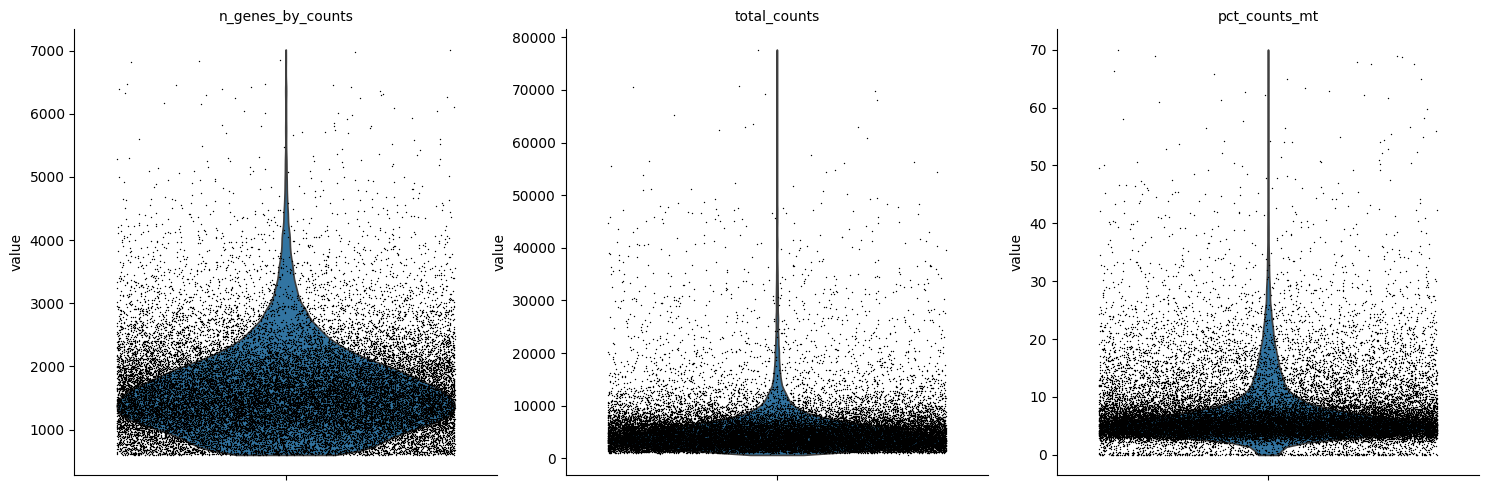

In [16]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# Normalization

Now, we normalize our data. We follow the typical count normalization and log1p transformation steps to normalize single-cell datasets for use with C2S. The only difference is that we perform the log1p transformation with base 10, rather than the default natural logarithm. We empirically found this base 10 log1p transformation to work well for inverse reconstruction of expression using a linear model, which will be shown in tutorial notebook 1.

In [17]:
# Count normalization
sc.pp.normalize_total(adata)
# Lop1p transformation with base 10 - base 10 is important for C2S transformation!
sc.pp.log1p(adata, base=10)

In [18]:
adata.X.max()

np.float32(3.408124)

With a base 10 log transformation, the largest value in our count matrix is now ~3.4, which is expected for a base-10 log transformation.

# Visualization

Now let's process our adata object for UMAP visualization of our dataset. We will run PCA, Scanpy's neighbors algorithm, and then the UMAP algorithm implemented by Scanpy.

In [19]:
sc.tl.pca(adata)

In [20]:
sc.pp.neighbors(adata)

In [21]:
sc.tl.umap(adata)

We can visualize the UMAPs of the processed data colored by donor, cell type, and tissue metadata

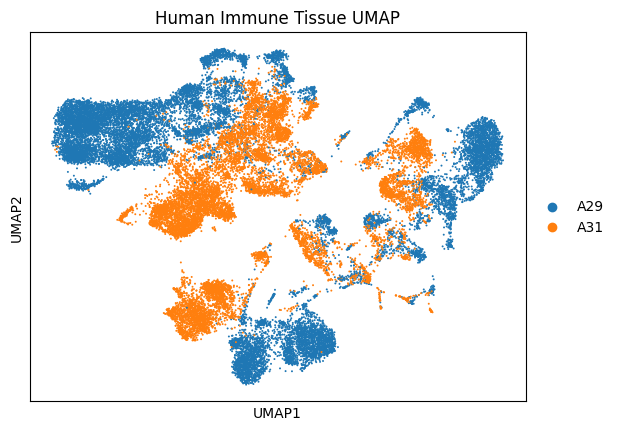

In [22]:
sc.pl.umap(
    adata,
    color="batch_condition",
    size=8,
    title="Human Immune Tissue UMAP",
)

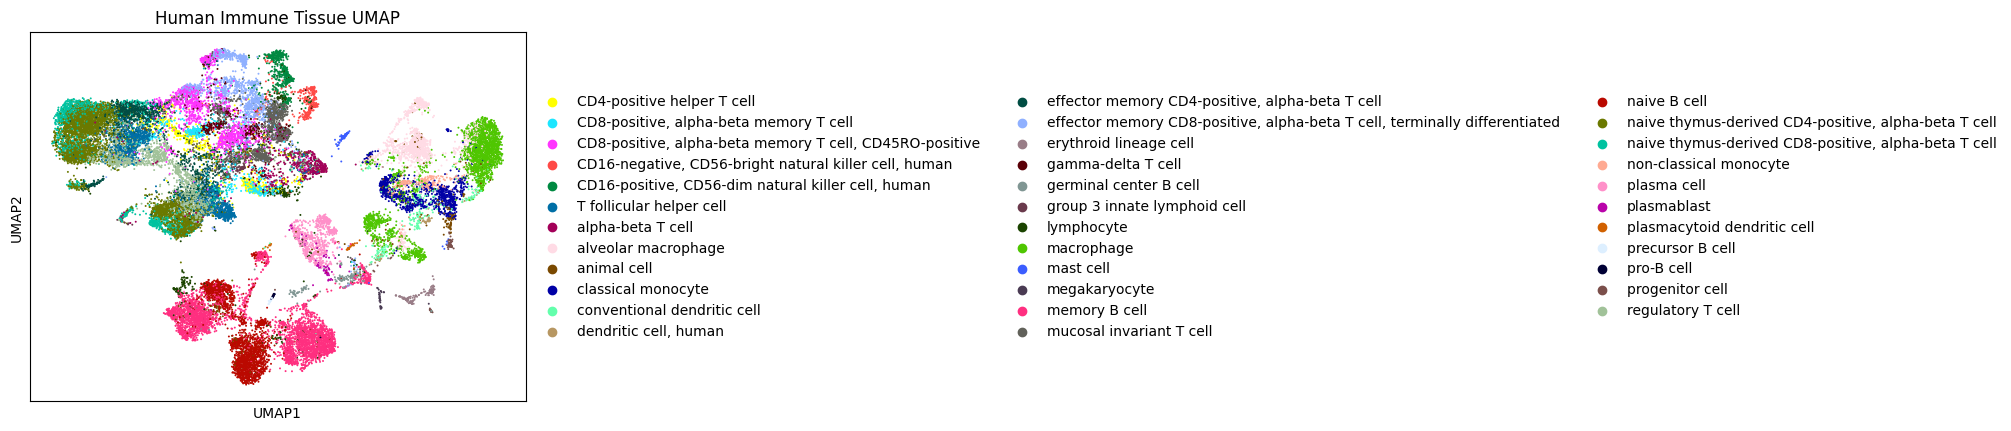

In [23]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

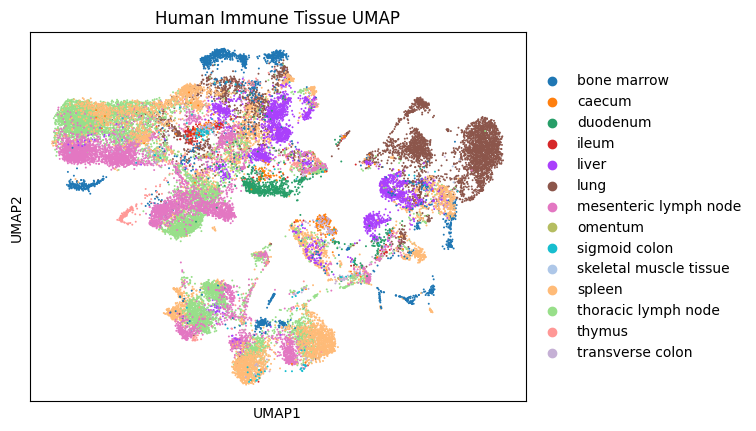

In [24]:
sc.pl.umap(
    adata,
    color="tissue",
    size=8,
    title="Human Immune Tissue UMAP",
)

Finally, we will save dataset to disk. This processed dataset will be used for all further tutorials, so make sure to keep this filepath handy.

In [25]:
SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/Cell2Sentence_Datasets/data_step_0.h5ad"

In [26]:
adata.write_h5ad(SAVE_PATH)

# Finetuning on a New Single-Cell Dataset

In this tutorial, we will demonstrate how to fine-tune an existing Cell2Sentence (C2S) model on a new single-cell RNA sequencing dataset. Fine-tuning is a crucial step in adapting a pretrained model to perform well on a specific task or dataset, improving its accuracy and generalization. This tutorial will guide you through the process of fine-tuning a C2S model to perform cell type prediction on a new dataset.

In this tutorial, you will:
1. Load an immune tissue single-cell dataset.
2. Format the dataset using a Prompt Formatter object, which prepares the data for the fine-tuning process.
3. Load a pretrained C2S model.
4. Fine-tune the C2S model to improve its performance on cell type prediction.

We will begin by importing the necessary libraries. These include Python's built-in libraries, third-party libraries for handling numerical computations, progress tracking, and specific libraries for single-cell RNA sequencing data and C2S operations.

In [27]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [28]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/Cell2Sentence_Datasets/data_step_0.h5ad"

In [29]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_condition_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
adata.obs = adata.obs[["cell_type", "tissue", "batch_condition", "organism", "sex"]]

In [31]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,sex
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,female


In [32]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


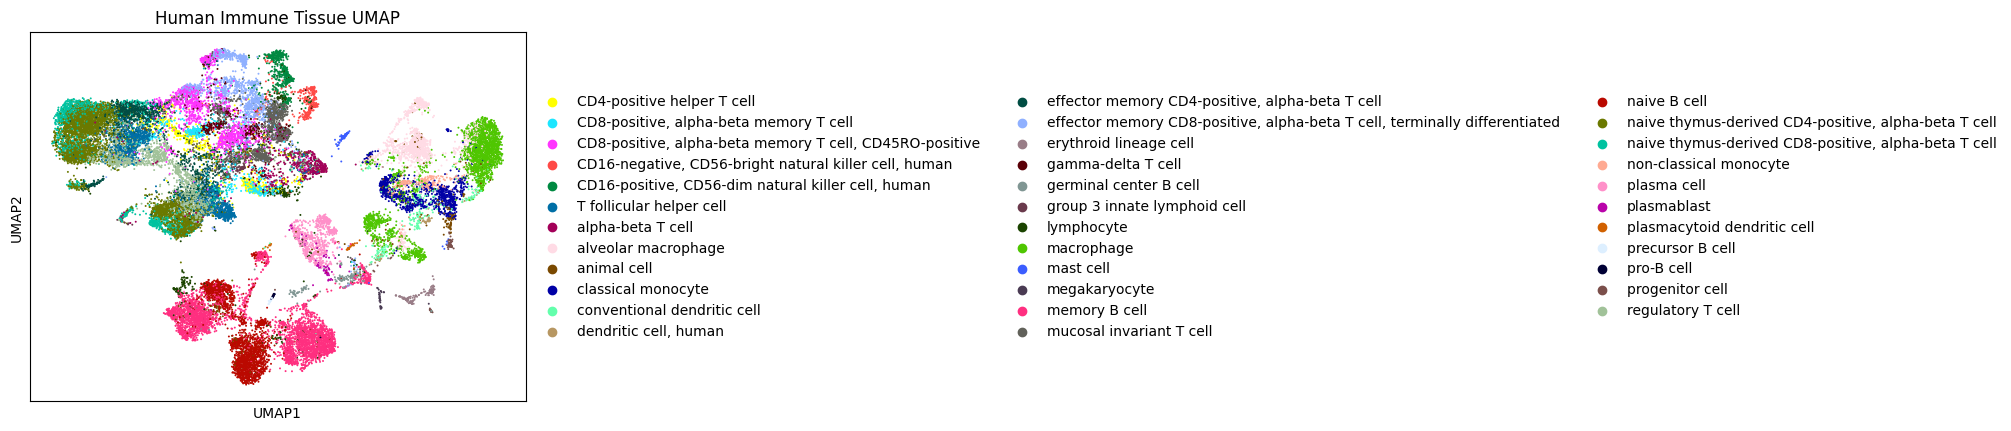

In [33]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [34]:
adata.X.max()

np.float32(3.408124)

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion + CSData Creation

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [35]:
adata_obs_cols_to_keep = ["cell_type", "tissue", "batch_condition", "organism", "sex"]

In [36]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata,
    random_state=SEED,
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 29773/29773 [00:16<00:00, 1813.36it/s]


In [37]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'Pan_T7935490_AAACCTGCAAATTGCC',
 'cell_sentence': 'RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14 HSP90AB1 RPL10A CXCR4 RPL4 EEF1B2 RPL36 RPS9 RPL27 NACA VIM H3-3B RPS7 HSPH1 ATP5F1E HLA-E RPL17 RPSA MYL12A RPL12 CD69 TAGAP RPL35 RPS29 RPL6 SARAF ZFP36L2 MT-ND4 ARHGDIB BTG1 RPS21 EEF1D PNRC1 EEF1G HSPA5 FYB1 CD3E IFITM1 RNASEK EEF2 MT-ND2 FTL S100A4 JUN IFITM2 CYTIP OST4 LAPTM5 RPL36AL PLAAT4 PFDN5 SAMSN1 DNAJA1 EIF4A1 FXYD5

In [38]:
c2s_save_dir = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "step3"  # This will be the name of our C2S dataset on disk

In [39]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds,
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/1 shards):   0%|          | 0/29773 [00:00<?, ? examples/s]

In [40]:
print(csdata)

CSData Object; Path=/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/step3, Format=arrow


# Load C2S Model

Now, we will load a C2S model which will finetune on a new dataset. This model can be a LLM pretrained on natural language, or it can be a trained C2S model which will undergo further finetuning on a new dataset of interest. Typically, starting from a pretrained C2S model benefits performance, since C2S models were initialized from natural language-pretrained LLMs and trained on many single-cell datasets on different tasks.

For this tutorial, we will start finetuning from the C2S-Pythia-410M cell type prediction model, which was trained to do cell type prediction on many datasets from CellxGene and Human Cell Atlas. We will finetune it for cell type prediction on our immune tissue dataset which we have loaded, which will help align the model with the cell type annotations present in this dataset as well as the expression profiles of the cells in our two donor samples. More details about the C2S-Pythia-410M cell type prediction model can be found in the Model Zoo section of the ReadME in the GitHub repo, or in the Huggingface model card.

We can define our CSModel object with our pretrained cell type prediction model as follows:

In [41]:
# Define CSModel object - Where to get the model (auto-download from Hugging Face)
cell_type_prediction_model_path = "vandijklab/C2S-Pythia-410m-cell-type-prediction"

# Choose where to save your outputs, and the name
save_dir = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3"
save_name = "cell_type_pred_pythia_410M_2"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

Note that the `model_name_or_path` parameter can be a name of a Huggingface model, for example 'EleutherAI/pythia-410m' for a 410 million parameter Pythia model pretrained on natural language (see https://huggingface.co/EleutherAI/pythia-410m), or it can be the path to a pretrained model saved on disk, as in the case in the cell above.

In [42]:
print(csmodel)

CSModel Object; Path=/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/cell_type_pred_pythia_410M_2


# Finetune on new dataset

Now, we will finetune our loaded C2S model on our immune tissue dataset. For training, we will need to define training arguments for finetuning our C2S model on our new dataset. Huggingface's Trainer class is used to do training, so we can utilize different training techniques (e.g. mixed precision training, gradient accumulation, gradient checkpointing, etc.) by specifying the corresponding option in the TrainingArguments object. This gives us a vast array of possible options for training, and will allow us to specify important parameters such as batch size, learning rate, and learning rate schedulers. See the full documentation for training arguments at:
- https://huggingface.co/docs/transformers/en/main_classes/trainer

First, we define our training task, which in our case will be cell type prediction. Possible values for the training task parameter can be found in the `prompt_formatter.py` file in the source code, under `SUPPORTED_TASKS`.

In [43]:
training_task = "cell_type_prediction"

We will create a datetimestamp to mark our training session:

In [44]:
datetimestamp = datetime.now().strftime('%Y-%m-%d-%H_%M_%S')
output_dir = os.path.join(csmodel.save_dir, datetimestamp + f"_finetune_{training_task}")
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
print(output_dir)

/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/2025-11-10-11_44_28_finetune_cell_type_prediction


And here, we define our training arguments. For this tutorial, we will use a batch size of 8 with 4 gradient accumulation steps, yielding an effective batch size of 32. We will use a learning rate of 1e-5 with a cosine annealing scheduler, and we will train for 5 epochs total. Some other important parameters specified here are:
- bf16: Uses mixed-precision training with bfloat16 dtype
- logging_steps: controls how often we log training loss
- eval_steps: controls how often we run the eval loop
- warmup_ratio: percentage of training in which learning rate warms up to the base learning rate specified

Full explanations of all possible training arguments can be found in the Huggingface Trainer documentation:

https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/trainer#transformers.TrainingArguments

In [45]:
train_args = TrainingArguments(
    bf16=True,
    fp16=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,
    learning_rate=1e-5,
    load_best_model_at_end=True,
    logging_steps=50,
    logging_strategy="steps",
    lr_scheduler_type="cosine",
    num_train_epochs=5,
    eval_steps=50,
    eval_strategy="steps",
    save_steps=100,
    save_strategy="steps",
    save_total_limit=3,
    warmup_ratio=0.05,
    output_dir=output_dir
)

In [46]:
csmodel.fine_tune(
    csdata=csdata,
    task=training_task,
    train_args=train_args,
    loss_on_response_only=False,
    top_k_genes=200,
    max_eval_samples=500,
)

Reloading model from path on disk: /content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/cell_type_pred_pythia_410M_2


Map (num_proc=3):   0%|          | 0/29773 [00:00<?, ? examples/s]

Starting training. Output directory: /content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/2025-11-10-11_44_28_finetune_cell_type_prediction
Selecting 500 samples of eval dataset to shorten validation loop.


/usr/local/lib/python3.12/dist-packages/cell2sentence/csmodel.py:210: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wand

Step,Training Loss,Validation Loss
50,1.455400,1.439567
100,1.419000,1.429876
150,1.417600,1.426892
200,1.425400,1.426636
250,1.419900,1.424232
300,1.424300,1.419890
350,1.403800,1.421558
400,1.416300,1.421037
450,1.399600,1.416429
500,1.409800,1.419131


Step,Training Loss,Validation Loss
50,1.455400,1.439567
100,1.419000,1.429876
150,1.417600,1.426892
200,1.425400,1.426636
250,1.419900,1.424232
300,1.424300,1.419890
350,1.403800,1.421558
400,1.416300,1.421037
450,1.399600,1.416429
500,1.409800,1.419131


Finetuning completed. Updated model saved to disk at: /content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/2025-11-10-11_44_28_finetune_cell_type_prediction


Our trained models are now saved in the output directory we specified in the training arguments. Huggingface will save the latest checkpoints of the training session, and will also keep the checkpoint which has the lowest validation loss.

In the next tutorial notebook (tutorial 4), we will see how to run cell type prediction inference with our trained model.

In [47]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [48]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/Cell2Sentence_Datasets/data_step_0.h5ad"

In [49]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_condition_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [50]:
adata.obs = adata.obs[["cell_type", "tissue", "batch_condition", "organism", "sex"]]

In [51]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,sex
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,female


In [52]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


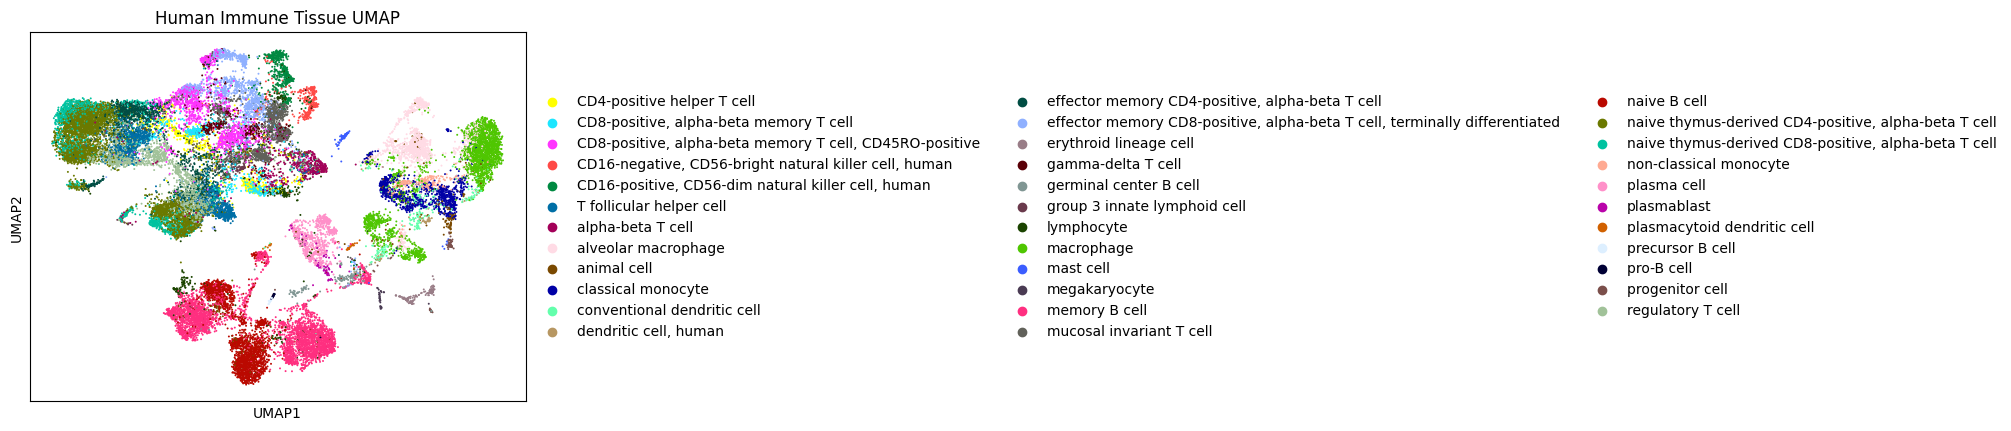

In [53]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [54]:
adata.X.max()

np.float32(3.408124)

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [55]:
adata_obs_cols_to_keep = ["cell_type", "tissue", "batch_condition", "organism", "sex"]

In [56]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata,
    random_state=SEED,
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 29773/29773 [00:17<00:00, 1701.78it/s]


In [57]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 29773
})

In [58]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'Pan_T7935490_AAACCTGCAAATTGCC',
 'cell_sentence': 'RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14 HSP90AB1 RPL10A CXCR4 RPL4 EEF1B2 RPL36 RPS9 RPL27 NACA VIM H3-3B RPS7 HSPH1 ATP5F1E HLA-E RPL17 RPSA MYL12A RPL12 CD69 TAGAP RPL35 RPS29 RPL6 SARAF ZFP36L2 MT-ND4 ARHGDIB BTG1 RPS21 EEF1D PNRC1 EEF1G HSPA5 FYB1 CD3E IFITM1 RNASEK EEF2 MT-ND2 FTL S100A4 JUN IFITM2 CYTIP OST4 LAPTM5 RPL36AL PLAAT4 PFDN5 SAMSN1 DNAJA1 EIF4A1 FXYD5

This time, we will leave off creating our CSData object until after we load our C2S model. This is because along with the model checkpoint, we saved the indices of train, val, and test set cells, which will allow us to select out test set cells for inference.

# Load C2S Model

Now, we will load a C2S model with which we will do cell type annotation. For this tutorial, this model will be the last checkpoint of the training session from <font color="red">tutorial notebook 3</font>, where we finetuned our cell type prediction model to do cell type prediction specifically on our immune tissue dataset. We will load the last checkpoint saved from training, and specify the same save_dir as we used before during training.
- <font color="red">Note:</font> If you are using your own data for this tutorial, make sure to switch out to the model checkpoint which you saved in tutorial notebook 3.
- If you want to annotate cell types without finetuning your own C2S model, then tutorial notebook 6 demonstrates how to load the C2S-Pythia-410M cell type prediction foundation model and use it to predict cell types without any finetuning.

We can define our CSModel object with our pretrained cell type prediction model as follows.

In [59]:
# Define CSModel object - Where to get the model (auto-download from Hugging Face) - alternative, you may fine-tune the model and apply here.

cell_type_prediction_model_path = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/2025-11-10-11_44_28_finetune_cell_type_prediction/checkpoint-3730"
  #cell_type_prediction_model_path = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/2025-11-09-21_39_02_finetune_cell_type_prediction/checkpoint-3730"

# Choose where to save your outputs, and the name
save_dir = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3"
save_name = "cell_type_pred_pythia_410M_inference"

csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


We will also load the data split indices saved alongside the C2S model checkpoint, so that we know which cells were part of the training and validation set. We will do inference on unseen test set cells, which are 10% of the original data.

In [60]:
base_path = "/".join(cell_type_prediction_model_path.split("/")[:-1])
print(cell_type_prediction_model_path)
print(base_path)

/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/2025-11-10-11_44_28_finetune_cell_type_prediction/checkpoint-3730
/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/2025-11-10-11_44_28_finetune_cell_type_prediction


In [61]:
with open(os.path.join(base_path, 'data_split_indices_dict.pkl'), 'rb') as f:
    data_split_indices_dict = pickle.load(f)
data_split_indices_dict.keys()

dict_keys(['train', 'val', 'test'])

In [62]:
print(len(data_split_indices_dict["train"]))
print(len(data_split_indices_dict["val"]))
print(len(data_split_indices_dict["test"]))

23847
2948
2978


Select out test set cells from full arrow dataset

In [63]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 29773
})

In [64]:
test_ds = arrow_ds.select(data_split_indices_dict["test"])
test_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 2978
})

Now, we will create our CSData object using only the test set cells:

In [65]:
c2s_save_dir = "/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "data_step4"  # This will be the name of our C2S dataset on disk


In [66]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=test_ds,
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/1 shards):   0%|          | 0/2978 [00:00<?, ? examples/s]

In [67]:
print(csdata)

CSData Object; Path=/content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/data_step4, Format=arrow


# Predict cell types

Now that we have loaded our finetuned cell type prediction model and have our test set, we will do cell type prediction inference using our C2S model. We can use the function predict_cell_types_of_data() from the tasks.py, which will take a CSModel() object and apply it to do cell type prediction on a CSData() object.

In [68]:
predicted_cell_types = predict_cell_types_of_data(
    csdata=csdata,
    csmodel=csmodel,
    n_genes=200
)

Reloading model from path on disk: /content/drive/MyDrive/Colab Notebooks/ARCT/cell2sentence-published-github/C2S_Files_Syed/c2s_api_testing/csmodel_step_3/cell_type_pred_pythia_410M_inference
Predicting cell types for 2978 cells using CSModel...


100%|██████████| 2978/2978 [17:45<00:00,  2.79it/s]


In [69]:
len(predicted_cell_types)

2978

In [70]:
predicted_cell_types[:3]

['CD8-positive, alpha-beta memory T cell.',
 'CD8-positive, alpha-beta memory T cell.',
 'CD8-positive, alpha-beta memory T cell.']

In [71]:
test_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 2978
})

In [72]:
total_correct = 0.0
for model_pred, gt_label in zip(predicted_cell_types, test_ds["cell_type"]):
    # C2S might predict a period at the end of the cell type, which we remove
    if model_pred[-1] == ".":
        model_pred = model_pred[:-1]

    if model_pred == gt_label:
        total_correct += 1

accuracy = total_correct / len(predicted_cell_types)

In [73]:
print("Accuracy:", accuracy)

Accuracy: 0.8310946944257891


In [74]:
for idx in range(0, 100, 10):
    print("Model pred: {}, GT label: {}".format(predicted_cell_types[idx], test_ds[idx]["cell_type"]))

Model pred: CD8-positive, alpha-beta memory T cell., GT label: CD8-positive, alpha-beta memory T cell
Model pred: CD4-positive helper T cell., GT label: CD4-positive helper T cell
Model pred: gamma-delta T cell., GT label: gamma-delta T cell
Model pred: macrophage., GT label: macrophage
Model pred: effector memory CD8-positive, alpha-beta T cell, terminally differentiated., GT label: effector memory CD8-positive, alpha-beta T cell, terminally differentiated
Model pred: macrophage., GT label: macrophage
Model pred: macrophage., GT label: macrophage
Model pred: macrophage., GT label: macrophage
Model pred: macrophage., GT label: macrophage
Model pred: macrophage., GT label: macrophage


We can see that our model achieves high accuracy 83.1%, correctly predicting the cell type of unseen cells from the immune tissue data 83.4% of the time! The model learned to predict cell type annotations in natural language effectively from a short finetuning period on the new data.